# Автоматическая загрузка и предобработка данных

In [1]:
from IPython.display import display
from IPython.display import HTML

from collections import OrderedDict

import numpy as np

import humanize as hz
import human_readable as hr

import pandas as pd

import config_logging as clog
import config_model as cfgm
import config as cfg
import data_load_model as dlm
import data_load as dl
import workflow as wf
import workflow_stage as wfs

2023-01-27 13:52:17,808 [MainThread  ] [INFO] {visions.backends} Pandas backend loaded 1.5.2
2023-01-27 13:52:17,813 [MainThread  ] [INFO] {visions.backends} Numpy backend loaded 1.23.5
2023-01-27 13:52:17,814 [MainThread  ] [INFO] {visions.backends} Pyspark backend NOT loaded
2023-01-27 13:52:17,815 [MainThread  ] [INFO] {visions.backends} Python backend loaded


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
config_loader = cfg.ConfigLoader.from_path('./config/config.yaml')
config = config_loader.load_config(
    print_short_report=True, print_verbose_report=False)

workflow_context = {'config': config}
data_load_command = wfs.DataLoadCommand()
data_tending_command = wfs.DataTendingCommand()
eda_post_tending_command = wfs.AutoEdaCommand(
    context_data_name='data',
    use_remote_data=True,
    eda_name='01-eda_post_tending',
    report_joined=True
)
# No missing values (NaNs) here
# No EDA after missing value treatment.
check_dates_command = wfs.CheckDatesCommand(
    use_remote_data=True
)
select_data_by_time_range_command = wfs.SelectDataByTimeRangeCommand(
    use_remote_data=True,
    selected_data_context_name='selected-data'
)
clear_data_command = wfs.DataClearingCommand(
    selected_data_context_name='selected-data'
)
prepared_data_report_command = wfs.PreparedDataReportCommand(
    selected_data_context_name='selected-data'
)
treat_data_command = wfs.DataTreatingCommand(
    selected_data_context_name='selected-data'
)
eda_post_treating_command = wfs.AutoEdaCommand(
    context_data_name='selected-data',
    use_remote_data=False,
    eda_name='09-eda_post_treating',
    report_joined=True
)

dataset_command = wfs.JoinedDatasetCommand(
    selected_data_context_name='selected-data',
    dataset_context_name='dataset',
    save_datasets=True
)


commands = OrderedDict[str, wf.AbstractCommand]()
commands['01-data_loading'] = data_load_command
commands['02-data_tending'] = data_tending_command
# commands['03-eda_post_tending_command'] = eda_post_tending_command
commands['04-check_dates_command'] = check_dates_command
commands['05-select_data_by_timerange_command'] = select_data_by_time_range_command
commands['06-clear_data_command'] = clear_data_command
commands['07-prepared_data_report_command'] = prepared_data_report_command
commands['08-treat_data_command'] = treat_data_command
# commands['09-eda_post_treating_command'] = eda_post_treating_command
commands['11-dataset_command'] = dataset_command


workflow = wf.Workflow(commands=commands)
workflow.execute(workflow_context)


2023-01-27 13:52:18,020 [MainThread  ] [INFO] {ConfigLoader} Found config file: ./config/config.yaml
2023-01-27 13:52:18,036 [MainThread  ] [INFO] {ConfigLoader} 
/================================================\
Loaded configuration short report:
------------------------------------------------
Research.
name: Tesla Stock Price Time Series Prediction
1. Target instrument.
    ticker: TSLA
    name:   Tesla, Inc.
    description:
            Tesla, Inc. engages in the design, development, manufacture, and sale of
        fully electric vehicles and energy generation and storage systems.
2. Extra quoted instruments.
    - Quoted instrument
        ticker: ^NDX
        name:   NASDAQ-100
        description:
                The index of today's modern-day industrials—comprised of 100 of the largest
            and most innovative non-financial companies listed on the Nasdaq
            Stock Market based on market capitalization.
    - Quoted instrument
        ticker: REMX
        name

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 904 entries, 2020-07-10 to 2022-12-30
Freq: D
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         904 non-null    float64
 1   high         904 non-null    float64
 2   low          904 non-null    float64
 3   close        904 non-null    float64
 4   volume       904 non-null    float64
 5   weekend      904 non-null    int64  
 6   holiday      904 non-null    int64  
 7   volume_^NDX  904 non-null    float64
 8   OHLC_^NDX    904 non-null    float64
 9   volume_REMX  904 non-null    float64
 10  OHLC_REMX    904 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 84.8 KB


<CommandState.SUCCESS: 1>

## Workflow-контекст автоматической обработки входных данных

### Ключи контекста

In [4]:
workflow_context.keys()


dict_keys(['config', 'data', 'selected-data', 'dataset_target', 'dataset_target_with_tech', 'dataset_joined', 'dataset_joined_with_tech'])

### Конфигурация - шаблонный отчёт

In [5]:
prepared_data_report_command.execute(workflow_context)


2023-01-27 13:52:20,143 [MainThread  ] [INFO] {PreparedDataReportCommand} ['begin_time=datetime.datetime(2020, 7, 10, 0, 0) end_time=datetime.datetime(2022, 12, 30, 0, 0)'] Preparing report...
2023-01-27 13:52:20,170 [MainThread  ] [INFO] {PreparedDataReportCommand} Report for prepared data.

🔬 Research
    name: Tesla Stock Price Time Series Prediction
    description:
        Based on the historical data of the Tesla stock prices and on other historical
        data of some quoted instruments (aka exogeneous variables).

🦾 Machine Learning
    ⤇ begin time: 2020-07-10 00:00:00
    ⥥ split date: 2022-12-10 00:00:00
    ⤆ end time: 2022-12-30 00:00:00
    ▒▒░▒ cross-validation strategy: sliding_window

📈 Target Quoted Instrument - [TSLA]
    ✅ ticker: TSLA
    ✅ name:   Tesla, Inc.
    ✅ description:
        Tesla, Inc. engages in the design, development, manufacture, and sale of fully
        electric vehicles and energy generation and storage systems.
    ✅ Time range:
        - begi

<CommandState.SUCCESS: 1>

### Целевой котируемый финансовый инструмент для предсказания - акции Tesla

In [6]:
config.research.target_quoted_instrument


QuotedInstrument(ticker='TSLA', name='Tesla, Inc.', description='Tesla, Inc. engages in the design, development, manufacture, and sale of fully electric vehicles and energy generation and storage systems.', data_loading=DataLoading(data_loading_stategy='load_remote_to_local_and_remote_as_latest', remote_data_loading=RemoteDataLoading(source_name='Yahoo! Finance', file_name='./data/target_quoted_instrument/TSLA/TSLA.csv', time_range=TimeRange(begin_time=datetime.datetime(2018, 1, 1, 0, 0), end_time=datetime.datetime(2022, 12, 31, 0, 0))), local_data_loading=LocalDataLoading(file_name='./data/target_quoted_instrument/TSLA/TSLA.csv'), date_column='Date'), data_transformation=DataTransformation(tending={'index': {'reset': ['localize']}, 'columns': {'remove': ['Dividends', 'Stock Splits'], 'change_rules': {'Volume': 'float'}, 'names': {'to_snake_case': True}}}, clearing={'missing_values': 'interpolate_by_previous_date'}, treatment={'dimensionality_reduction': 'None'}, scaling={'scalers': ['

#### Справка

> A Quoted Instrument refers to a financial instrument for which quoted prices reflecting normal market transactions are readily and regularly
> available from an exchange, dealer, broker, industry group, pricing service or regulatory agency. When quoted prices reflecting normal
> market transactions are not readily and regularly available from an exchange, dealer, broker, industry group, pricing service or regulatory
> agency, such financial instrument is referred to as unquoted instrument.

Source:
[Valuation Dictionary - Quoted Instrument](https://www.valupaedia.com/index.php/business-dictionary/420-quoted-instrument) -
[https://www.valupaedia.com/index.php/business-dictionary/420-quoted-instrument](https://www.valupaedia.com/index.php/business-dictionary/420-quoted-instrument)

Коротко: про _котируемый_ финансовый инструмент есть открытые биржевые данные. Иначе он _некотируемый_ (закрытый, секретный).


### Сырой входной датасет целевого финансового инструмента - TSLA (акции Tesla)

In [7]:
raw_data = workflow_context['data'][config.research.target_quoted_instrument.ticker].remote_data.loaded_data
raw_data[raw_data.index >=
         config.research.machine_learning.time_range.begin_time].head(15)


open        high         low       close       volume
Date                                                                   
2020-07-10   93.066666  103.261330   91.734001  102.976669  350064000.0
2020-07-13  110.599998  119.666000   98.073997   99.804001  584781000.0
2020-07-14  103.733330  106.000000   95.400002  101.120003  351271500.0
2020-07-15  102.866669  103.333336   97.133331  103.067329  245517000.0
2020-07-16   98.477333  102.113998   97.733330  100.042664  214512000.0
2020-07-17  100.896667  102.500664   99.333336  100.056000  139950000.0
2020-07-20  101.267334  110.000000   99.199997  109.533333  256821000.0
2020-07-21  109.328667  111.666664  103.866669  104.557335  241608000.0
2020-07-22  106.599998  108.428001  104.133331  106.155334  212416500.0
2020-07-23  111.930000  112.599998   98.718002  100.871330  364927500.0
2020-07-24   94.400665   97.666664   91.102669   94.466667  290949000.0
2020-07-27   95.666664  103.195999   94.199997  102.639999  240730500.0
2020-07-28  100.266670  104.313332   98.294670   98.432671  237130500.0
2020-07-29  100.066666  102.320663   99.133331   99.940666  141403500.0
2020-07-30   99.199997  100.882668   98.066666   99.166000  114315000.0

Видно, что есть пропуски в выходных днях, когда биржи не работают и цены замораживаются.<br>
Было решено заполнить выходные ценами в предыдущий день.


### Датасет с заполненными выходными днями

In [8]:
workflow_context['selected-data'][config.research.target_quoted_instrument.ticker].head(
    15)


open        high         low       close       volume  weekend  holiday
date                                                                                     
2020-07-10   93.066666  103.261330   91.734001  102.976669  350064000.0        0        0
2020-07-11   93.066666  103.261330   91.734001  102.976669  350064000.0        1        0
2020-07-12   93.066666  103.261330   91.734001  102.976669  350064000.0        1        0
2020-07-13  110.599998  119.666000   98.073997   99.804001  584781000.0        0        0
2020-07-14  103.733330  106.000000   95.400002  101.120003  351271500.0        0        0
2020-07-15  102.866669  103.333336   97.133331  103.067329  245517000.0        0        0
2020-07-16   98.477333  102.113998   97.733330  100.042664  214512000.0        0        0
2020-07-17  100.896667  102.500664   99.333336  100.056000  139950000.0        0        0
2020-07-18  100.896667  102.500664   99.333336  100.056000  139950000.0        1        0
2020-07-19  100.896667  102.500664   99.333336  100.056000  139950000.0        1        0
2020-07-20  101.267334  110.000000   99.199997  109.533333  256821000.0        0        0
2020-07-21  109.328667  111.666664  103.866669  104.557335  241608000.0        0        0
2020-07-22  106.599998  108.428001  104.133331  106.155334  212416500.0        0        0
2020-07-23  111.930000  112.599998   98.718002  100.871330  364927500.0        0        0
2020-07-24   94.400665   97.666664   91.102669   94.466667  290949000.0        0        0

Видно, что пропуски заполнены ценами за предыдущий рабочий день биржи.<br>
Аналогично со всеми тикерами вспомогательных котируемых финансовых инструментов:


In [9]:
temp = (display(HTML(f"📈 <b>{it.ticker}</b>"))
        for it in config.research.quoted_instruments)
next(temp)
next(temp)


### Выбранный период для обучения и тестирования моделей

In [10]:
config.research.machine_learning.time_range


TimeRange(begin_time=datetime.datetime(2020, 7, 10, 0, 0), end_time=datetime.datetime(2022, 12, 30, 0, 0))

#### Временная метка для отделения тестового набора данных

In [11]:
config.research.machine_learning.split_time


datetime.datetime(2022, 12, 10, 0, 0)

# Визуализация наборов данных

In [12]:
dataset_target = workflow_context['dataset_target']
dataset_target_with_tech = workflow_context['dataset_target_with_tech']

dataset_joined = workflow_context['dataset_joined']
dataset_joined_with_tech = workflow_context['dataset_joined_with_tech']


In [13]:
monthly_index = pd.date_range(start=dataset_target.index.min(), end=dataset_target.index.max(), freq='MS')
monthly_ticks = monthly_index.to_list()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
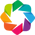

In [14]:
import holoviews as hv
from holoviews import opts
from holoviews.operation.timeseries import rolling


hv.extension('bokeh')

In [294]:
def a_curve(data: pd.Series, title: str = 'value', label: str = None, xlabel: str = 'date') -> hv.Curve:
    label = data.name if label is None else label
    data_copy = data.copy(deep=True)
    return hv.Curve(data_copy, xlabel, (label, title), label=label)

## Данные целевого ряда - TSLA (Tesla)

In [16]:
hv.Dimension.type_formatters[np.datetime64] = '%Y-%m'
(
    a_curve(dataset_target['open']) *
    a_curve(dataset_target['high']) *
    a_curve(dataset_target['low']) *
    a_curve(dataset_target['close'])
).opts(
    opts.Curve(color=hv.Cycle(values=['cyan', 'red', 'navy', 'olive'])),
    opts.Overlay(width=1024, height=400, legend_position='top_left', xrotation=45, xticks=monthly_ticks)
)

:Overlay
   .Curve.Open  :Curve   [date]   (open)
   .Curve.High  :Curve   [date]   (high)
   .Curve.Low   :Curve   [date]   (low)
   .Curve.Close :Curve   [date]   (close)

## Данные OHLC (усреднённая кривая)

In [17]:
hv.Dimension.type_formatters[np.datetime64] = '%Y-%m'
(
    a_curve(dataset_target_with_tech['Bollinger_Upper_TSLA']) *
    a_curve(dataset_target_with_tech['OHLC_TSLA']) *
    a_curve(dataset_target_with_tech['Bollinger_Lower_TSLA'])
).opts(
    opts.Curve(color=hv.Cycle(values=['red', 'black', 'navy'])),
    opts.Overlay(width=1024, height=400, legend_position='top_left', xrotation=45, xticks=monthly_ticks)
)

:Overlay
   .Curve.Bollinger_Upper_TSLA :Curve   [date]   (Bollinger_Upper_TSLA)
   .Curve.OHLC_TSLA            :Curve   [date]   (OHLC_TSLA)
   .Curve.Bollinger_Lower_TSLA :Curve   [date]   (Bollinger_Lower_TSLA)

# EDA для собранных данных

Используем таблицу с экзогенными переменными и с признаками теханализа для акций Tesla.

В этом исследовании не используются данные скоректированной цены закрытия торгов с учётом дивидендов (признак adjusted close).<br>
Сравнивать будем усреднённые OHLC цены на финансовые инструменты либо цены на моменты закрытия биржи - close, в зависимости от удобства.

\begin{equation}
OHLC = \frac{1}{4} \cdot \left( open + high + low + close \right)
\end{equation}

Также OHLC или close будут использоваться для упрощённого анализа одномерного временного ряда вместо многомерного временного ряда для акций Tesla. 

In [18]:
dataset_joined_with_tech.head()

open       high        low       close       volume  weekend  holiday   volume_^NDX     OHLC_^NDX  volume_REMX  OHLC_REMX   OHLC_TSLA    HLC_TSLA  close_diff_TSLA  MA200_TSLA  MA100_TSLA  MA50_TSLA  MA26_TSLA  MA20_TSLA  MA12_TSLA    MA4_TSLA    MA3_TSLA  DIFF-MA200-MA50_TSLA  DIFF-MA200-MA100_TSLA  DIFF-MA200-CLOSE_TSLA  DIFF-MA100-CLOSE_TSLA  DIFF-MA50-CLOSE_TSLA  MA200_low_TSLA  MA14_low_TSLA  MA200_high_TSLA  MA14_high_TSLA  MA20dSTD_TSLA  EMA12_TSLA  EMA20_TSLA  EMA26_TSLA  EMA100_TSLA  EMA200_TSLA  close_shift-1_TSLA  close_shift-2_TSLA  Bollinger_Upper_TSLA  Bollinger_Lower_TSLA  K-ratio_TSLA  RSI_TSLA  MACD_TSLA
date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2020-07-10   93.066666  103.26133  91.734001  102.976669  350064000.0        0        0  3.537510e+09  10767.590088      57700.0  35.947430   97.759666   99.324000       123.180000      123.18      123.18     123.18     123.18     123.18     123.18  123.180000  123.180000                123.18                 123.18                 123.18                 123.18                123.18          123.18         123.18           123.18          123.18         123.18  102.976669  102.976669  102.976669   102.976669   102.976669          102.976669          102.976669                123.18                123.18        123.18    123.18   0.000000
2020-07-11   93.066666  103.26133  91.734001  102.976669  350064000.0        1        0  3.537510e+09  10767.590088      57700.0  35.947430   97.759666   99.324000         0.000000      123.18      123.18     123.18     123.18     123.18     123.18  123.180000  123.180000                123.18                 123.18                 123.18                 123.18                123.18          123.18         123.18           123.18          123.18         123.18  102.976669  102.976669  102.976669   102.976669   102.976669          102.976669           99.804001                123.18                123.18        123.18    123.18   0.000000
2020-07-12   93.066666  103.26133  91.734001  102.976669  350064000.0        1        0  3.537510e+09  10767.590088      57700.0  35.947430   97.759666   99.324000         0.000000      123.18      123.18     123.18     123.18     123.18     123.18  123.180000  102.976669                123.18                 123.18                 123.18                 123.18                123.18          123.18         123.18           123.18          123.18         123.18  102.976669  102.976669  102.976669   102.976669   102.976669           99.804001          101.120003                123.18                123.18        123.18    123.18   0.000000
2020-07-13  110.599998  119.66600  98.073997   99.804001  584781000.0        0        0  4.851880e+09  10799.392334      87000.0  37.255489  107.035999  105.848000        -3.172668      123.18      123.18     123.18     123.18     123.18     123.18  102.183502  101.919113                123.18                 123.18                 123.18                 123.18                123.18          123.18         123.18           123.18          123.18         123.18  102.488566  102.674510  102.741657   102.913844   102.945100          101.120003          103.067329                123.18                123.18        123.18    123.18  -0.253090
2020-07-14  103.733330  106.00000  95.400002  101.120003  351271500.0        0        0  4.461770e+09  10566.259766      45700.0  36.604930  1

## Скользящие средние для close

Признаки (из тех, что соответствуют теханализу) MA200_TSLA, MA100_TSLA, MA50_TSLA, MA26_TSLA, MA20_TSLA, MA12_TSLA рассчитаны по цене закрытия.
Также дополнитель подсчитаны MA4_TSLA и MA3_TSLA.

In [19]:
hv.Dimension.type_formatters[np.datetime64] = '%Y-%m'
(
    a_curve(dataset_joined_with_tech['close']) *
    a_curve(dataset_joined_with_tech['MA200_TSLA']) *
    a_curve(dataset_joined_with_tech['MA100_TSLA']) *
    a_curve(dataset_joined_with_tech['MA50_TSLA']) *
    a_curve(dataset_joined_with_tech['MA26_TSLA']) *
    a_curve(dataset_joined_with_tech['MA20_TSLA']) *
    a_curve(dataset_joined_with_tech['MA12_TSLA']) *
    a_curve(dataset_joined_with_tech['MA4_TSLA']) *
    a_curve(dataset_joined_with_tech['MA3_TSLA'])
).opts(
    opts.Curve(color=hv.Cycle(values=['#000000', '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600'])),
    opts.Overlay(width=1024, height=400, legend_position='top_left', xrotation=45, xticks=monthly_ticks)
)

:Overlay
   .Curve.Close      :Curve   [date]   (close)
   .Curve.MA200_TSLA :Curve   [date]   (MA200_TSLA)
   .Curve.MA100_TSLA :Curve   [date]   (MA100_TSLA)
   .Curve.MA50_TSLA  :Curve   [date]   (MA50_TSLA)
   .Curve.MA26_TSLA  :Curve   [date]   (MA26_TSLA)
   .Curve.MA20_TSLA  :Curve   [date]   (MA20_TSLA)
   .Curve.MA12_TSLA  :Curve   [date]   (MA12_TSLA)
   .Curve.MA4_TSLA   :Curve   [date]   (MA4_TSLA)
   .Curve.MA3_TSLA   :Curve   [date]   (MA3_TSLA)

Скользящие средние, с общепринятыми для анализа биржевых цен величинами окон, сильно запаздывающе и грубо описывают изменения цены закрытия (close) для такого инструмента, как акции Tesla. Как дополнительные переменные они могут пригодиться для построения более дорогой модели машинного обучения.

Из графков видно, что возможно стоит взять окно, меньшее, чем рабочая неделя - 3, 4 дня и использовать такое скользящее среднее как дополнительный признак при обучении более сложной модели.

Явного постоянного тренда у ряда нет. Локальные тренды в течение от нескольких месяцев до года могут быть обусловлены эпидемией COVID-19, военным конфликтом и усилившемся глобальным экономическим кризисом. В любом случае для торговли стоит строить модели, предсказывающие ценя на несколько ближайших дней с памятью примерно от двух недель до месяца.

## Упрощённый EDA временных данных

Возьмём только цену закрытия и OHLC для анализа.

In [20]:
datasimple = dataset_joined_with_tech[['close', 'OHLC_TSLA']]
datasimple.head(5)

close   OHLC_TSLA
date                              
2020-07-10  102.976669   97.759666
2020-07-11  102.976669   97.759666
2020-07-12  102.976669   97.759666
2020-07-13   99.804001  107.035999
2020-07-14  101.120003  101.563334

### Разделение выборки

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting import model_selection


y_train, y_test, X_train, X_test = model_selection.temporal_train_test_split(
    y=datasimple['close'], X=datasimple[['OHLC_TSLA']], test_size=0.05
)
print(f"y_train: {y_train.shape}")
print(f"X_train: {X_train.shape}")
print('--------------------------------')
print(f"y_test: {y_test.shape}")
print(f"X_test: {X_test.shape}")

y_train: (858,)
X_train: (858, 1)
--------------------------------
y_test: (46,)
X_test: (46, 1)


### Декомпозиция на тренд и сезонность

In [184]:
from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose


def plot_seasonal_decompose(decompose_result,
                            observed=True, seasonal=True, trend=True, resid=True,
                            size_inches: tuple=(15, 7)):
    fig = decompose_result.plot([observed, seasonal, trend, resid])
    fig.set_size_inches(*size_inches)
    fig.tight_layout(h_pad=0.0, w_pad=0.0)
    plt.show()

/home/sorcerer/Projects/DataScience/Stock/Work/Dione/dione/lib/python3.10/site-packages/statsmodels/tsa/seasonal.py:338: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


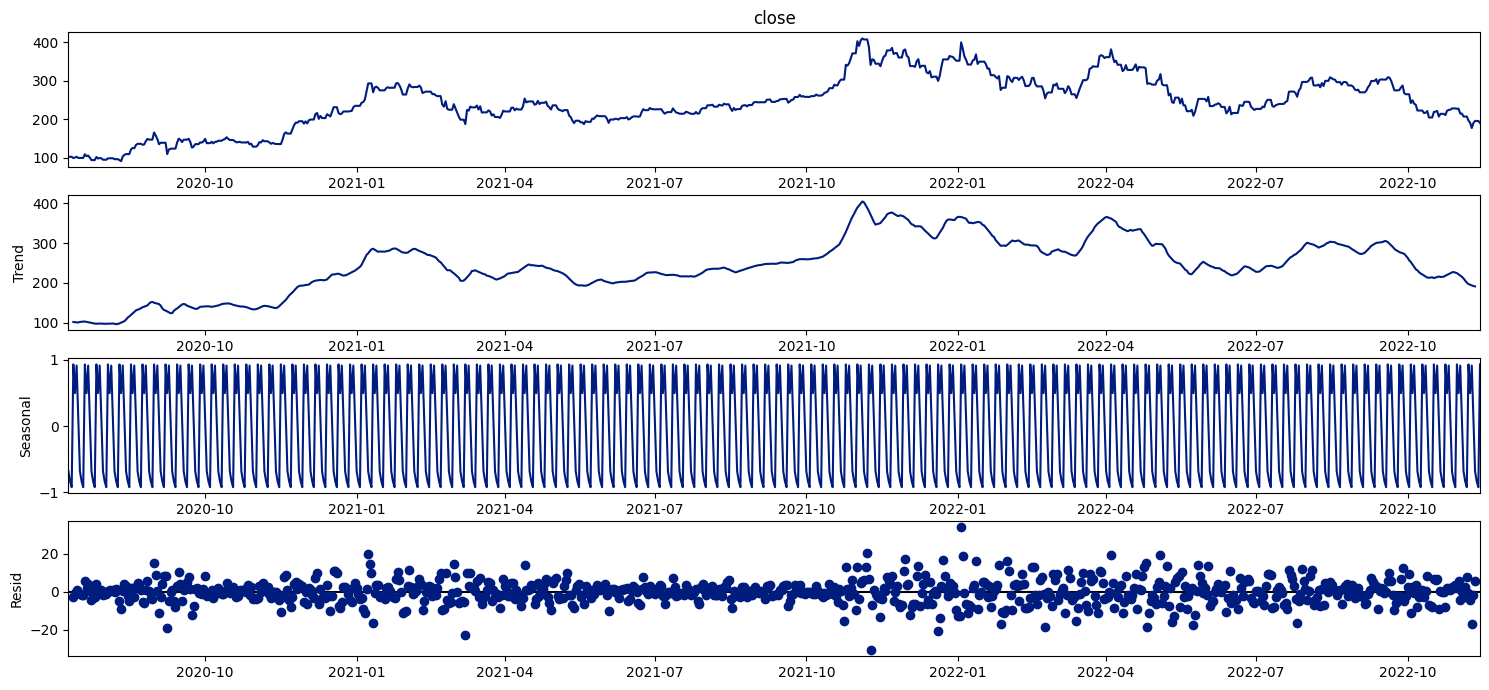

In [185]:
plot_seasonal_decompose( seasonal_decompose(y_train, model='additive'), size_inches=(15, 7) )

- Тренд непостоянный - имеет смысл предсказывать только на несколько дней вперёд.
- Видна недельнная сезонность из-за выходных дней.
- Диаграмма остатков содержит меняющуюся со временем дисперсию.

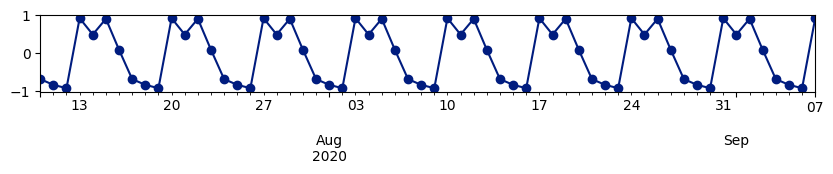

In [463]:
plt.rcParams["figure.figsize"] = 10, 1
seasonal_decompose(y_train, model='additive').seasonal[:60].plot(marker='o')
plt.show()

#### Спектр

In [489]:
# ----------------------------------------------------------------
# Sampling
# Removing the moving average
y_train_no_MA = y_train - dataset_target_with_tech['MA3_TSLA'].loc[y_train.index]
# ----------------------
# Number of samples
N = len(y_train_no_MA)
# ----------------------
# Sampling rates
# 1. Time: one day
one_day_seconds = 60 * 60 * 24
sampling_rate_days = 1
sampling_rate_seconds = sampling_rate_days * one_day_seconds
# Fundamental period
# T_0 = N * sampling_rate_seconds
# 2. Frequencies: Hertz
sampling_rate_hertz = 1 / sampling_rate_seconds
# 3. Day frequency threshold
higher_days_thresold = 36
lower_day_frequency_threshold_herz = 1 / ( higher_days_thresold * one_day_seconds )

lower_days_thresold = 2
higher_day_frequency_threshold_herz = 1 / ( lower_days_thresold * one_day_seconds )
# ----------------------
# ----------------------------------------------------------------
# Frequencies
# amplitude_indexes = np.arange(0, N)
# frequencies =  amplitude_indexes / T_0
frequencies = np.fft.fftfreq(n=N, d=sampling_rate_seconds)
amplitudes = np.fft.fft(y_train_no_MA)
amplitude_modules = np.abs(amplitudes) / N
# ----------------------------------------------------------------
# Periodogram
# N_half_spectrum = N // 2
psd_frequencies = frequencies[(frequencies > 0) & (frequencies <= higher_day_frequency_threshold_herz)]
psd_amplitudes = amplitude_modules[(frequencies > 0) & (frequencies <= higher_day_frequency_threshold_herz)]
psd_data = pd.Series(np.abs(psd_amplitudes), index=psd_frequencies)

psd_higher_frequencies = frequencies[
    (frequencies >= lower_day_frequency_threshold_herz) & (frequencies <= higher_day_frequency_threshold_herz)]
psd_higher_freq_amplitudes = amplitude_modules[
    (frequencies >= lower_day_frequency_threshold_herz) & (frequencies <= higher_day_frequency_threshold_herz)]
psd_higher_freq_data = pd.Series(np.abs(psd_higher_freq_amplitudes), index=psd_higher_frequencies)

def psd_frequency_formatter(frequency_herz):
    return f"1 / {( (1 / frequency_herz) / (60 * 60 * 24) ):.4f}d"

display(
    (
        hv.Curve(psd_data).opts(line_width=1.5, color='red') *
        hv.Scatter(psd_data).opts(size=6, marker='o', color='blue')
    ).opts(
        title='Periodogram/Spectrum of the Tesla Stock Close Price',
        xlabel='Frequency (Day⁻¹)',
        xticks=psd_frequencies, xformatter=psd_frequency_formatter, xrotation=90, logx=True,
        ylabel='|Amplitude| / N',
        width=1024, height=400, show_grid=True
    )
)
display(
    (
        hv.Curve(psd_higher_freq_data).opts(line_width=1.5, color='red') *
        hv.Scatter(psd_higher_freq_data).opts(size=6, marker='o', color='blue')
    ).opts(
        title='Periodogram/Spectrum of the Tesla Stock Close Price: 2 - 36 days.',
        xlabel='Frequency (Day⁻¹)',
        xticks=psd_frequencies, xformatter=psd_frequency_formatter, xrotation=90, logx=True,
        ylabel='|Amplitude| / N',
        width=1024, height=400, show_grid=True
    )
)

:Overlay
   .Curve.I   :Curve   [index]   (_)
   .Scatter.I :Scatter   [index]   (_)

:Overlay
   .Curve.I   :Curve   [index]   (_)
   .Scatter.I :Scatter   [index]   (_)

Особенной интересны следующие периоды:
- 3 дня (3.1200)
- 4 дня (3.9722)
- 5 дней (5.0471)
- 13 дней (≡13.0000)
- 29, 30 дней (29.5862)
- 37 дней (37.3043)
- 51 день (50.4706)
- 71 день (71.5000)
- 143 дня (143.0000)

На сезонных диаграммах ниже это ярко заметно.

In [507]:
from math import isclose

found_periodic_days = [3.1200, 3.9722, 5.0471, 29.5862, 37.3043, 50.4706, 71.5000, 143.0000]
found_frequencies_mask = list[bool]()
for frequency in frequencies:
    for periodic_day in found_periodic_days:
        if np.abs(frequency) > 1e-10 and \
            isclose( np.abs((1 / frequency) / (60 * 60 * 24)), periodic_day, rel_tol=1e-6, abs_tol=1e-3 ):
            found_frequencies_mask.append(True)
            break
    else:
        found_frequencies_mask.append(False)

discrete_frequencies = frequencies[found_frequencies_mask]
discrete_periods_days = (1 / found_frequencies) / (60 * 60 * 24)

discrete_amplitudes = amplitudes[found_frequencies_mask]
discrete_amplitude_values = np.abs(discrete_amplitudes)
discrete_phases = np.angle(discrete_amplitudes)

print('----------------------------------------------------------------')
print(f"Found periods in days:\n{discrete_periods_days}")
print('------------------------------------------')
print(f"Found frequencies:\n{discrete_frequencies}")
print('------------------------------------------')
print(f"Found amplitudes:\n{discrete_amplitudes}")
print('------------------------------------------')
print(f"Found amplitude values:\n{discrete_amplitude_values}")
print('----------')
print(f"Found phases (radians):\n{discrete_phases}")
print('----------------------------------------------------------------')

----------------------------------------------------------------
Found periods in days:
[ 143.           71.5          50.47058824   37.30434783   29.5862069
    5.04705882    3.97222222    3.12         -3.12         -3.97222222
   -5.04705882  -29.5862069   -37.30434783  -50.47058824  -71.5
 -143.        ]
------------------------------------------
Found frequencies:
[ 8.09375809e-08  1.61875162e-07  2.29323146e-07  3.10260727e-07
  3.91198308e-07  2.29323146e-06  2.91375291e-06  3.70963913e-06
 -3.70963913e-06 -2.91375291e-06 -2.29323146e-06 -3.91198308e-07
 -3.10260727e-07 -2.29323146e-07 -1.61875162e-07 -8.09375809e-08]
------------------------------------------
Found amplitudes:
[  68.6845616 -465.31107817j -316.27985767+288.10519857j
 -346.60123314+118.04723786j -357.78828441-108.78146487j
  347.2542112 -148.67044553j  245.31390297-301.83093814j
 -105.89130259+398.09081296j -287.63956345+208.89411281j
 -287.63956345-208.89411281j -105.89130259-398.09081296j
  245.31390297+301.830

#### Отдельные периоды сезонности.

In [278]:
plt.rcParams["figure.figsize"] = 10, 1

#### ❓ 2 дня

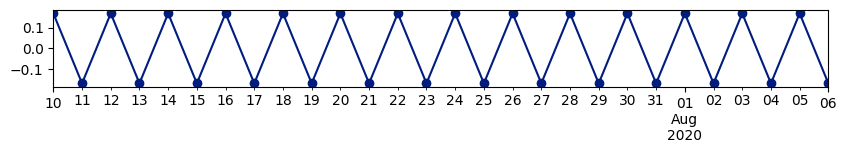

In [279]:
seasonal_decompose(y_train, period=2, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ✅ 3 дня

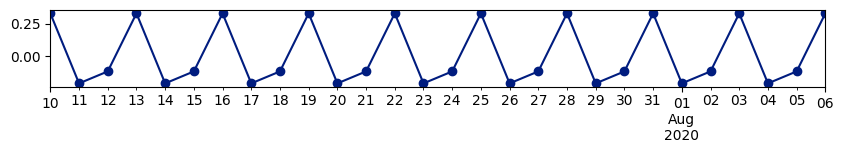

In [280]:
seasonal_decompose(y_train, period=3, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ✅ 4 дня

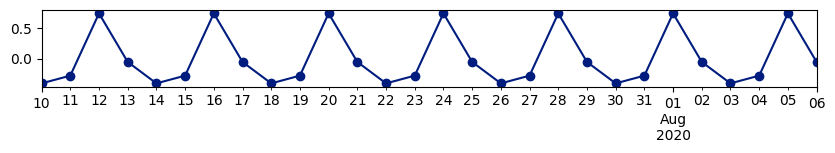

In [441]:
seasonal_decompose(y_train, period=4, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ✅ 5 дней

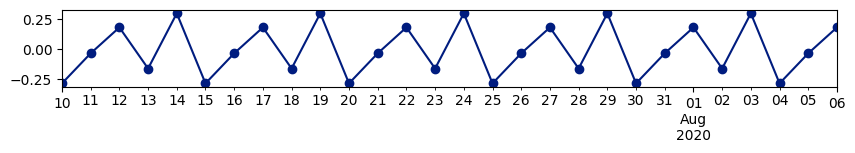

In [439]:
seasonal_decompose(y_train, period=5, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ❓ 6 дней

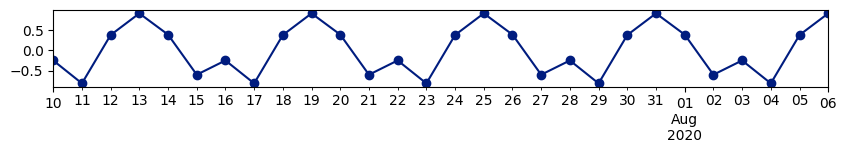

In [440]:
seasonal_decompose(y_train, period=6, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ❓ 7 дней

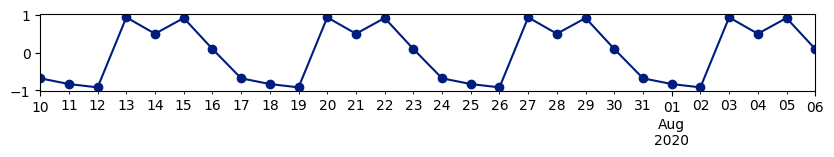

In [282]:
seasonal_decompose(y_train, period=7, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ❓ 11 дней

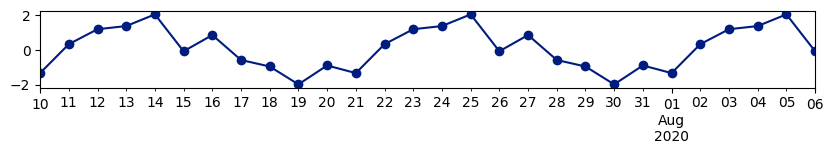

In [442]:
seasonal_decompose(y_train, period=11, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ❓ 12 дней

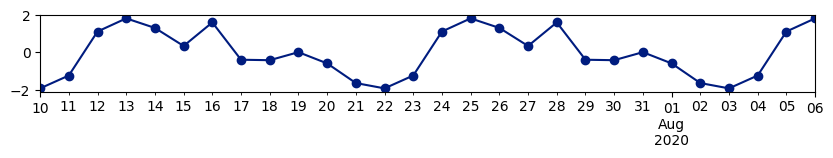

In [444]:
seasonal_decompose(y_train, period=12, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ✅ 13 дней

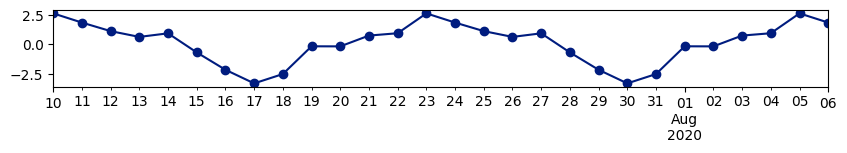

In [437]:
seasonal_decompose(y_train, period=13, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ❓ 14 дней

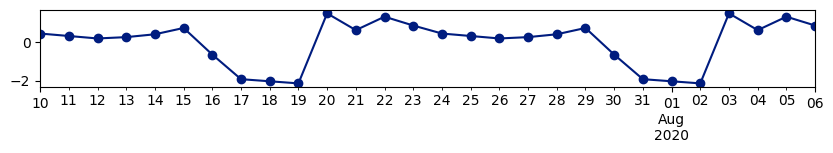

In [283]:
seasonal_decompose(y_train, period=14, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ❓ 18 дней

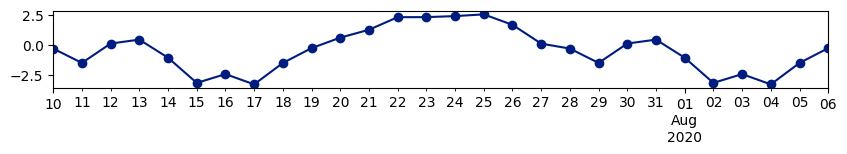

In [445]:
seasonal_decompose(y_train, period=18, model='additive').seasonal[:28].plot(marker='o')
plt.show()

#### ✅ 29 дней

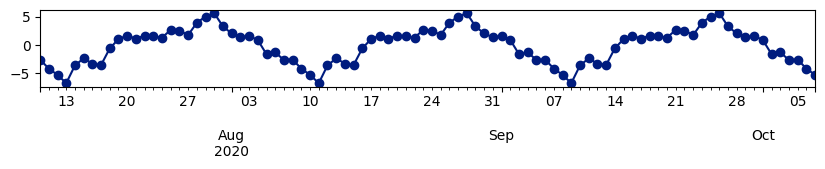

In [284]:
seasonal_decompose(y_train, period=29, model='additive').seasonal[:90].plot(marker='o')
plt.show()

#### ✅ 30 дней

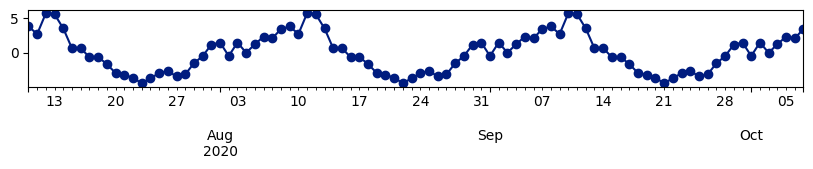

In [446]:
seasonal_decompose(y_train, period=30, model='additive').seasonal[:90].plot(marker='o')
plt.show()

#### ✅ 37 дней

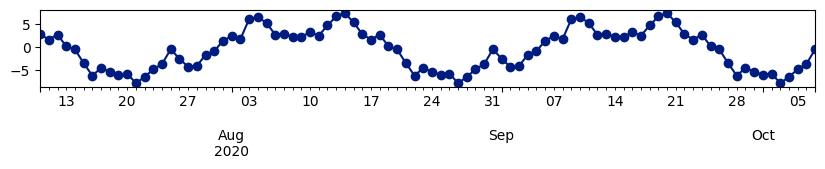

In [476]:
seasonal_decompose(y_train, period=37, model='additive').seasonal[:90].plot(marker='o')
plt.show()

#### ✅ 51 день

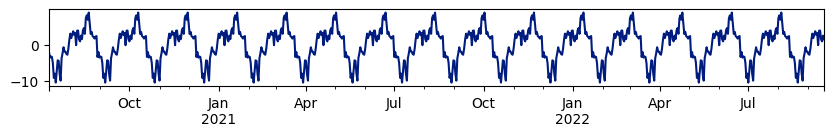

In [478]:
seasonal_decompose(y_train, period=51, model='additive').seasonal[:800].plot()
plt.show()

#### ✅ 71 день

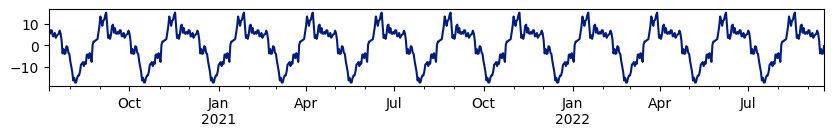

In [461]:
seasonal_decompose(y_train, period=71, model='additive').seasonal[:800].plot()
plt.show()

#### ✅ 143 дня

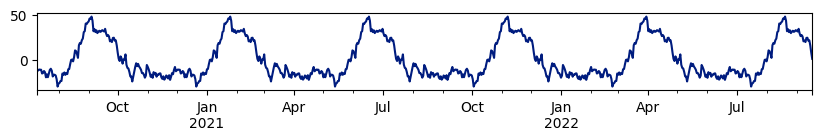

In [454]:
seasonal_decompose(y_train, period=143, model='additive').seasonal[:800].plot()
plt.show()

#### ❓ 286 дней

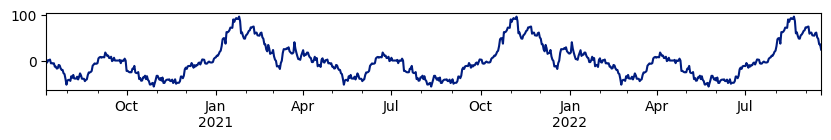

In [449]:
seasonal_decompose(y_train, period=286, model='additive').seasonal[:800].plot()
plt.show()

### Коррелограммы

In [25]:
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


def plot_acf(data, lags: int, size_inches: tuple):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(*size_inches)
    sgt.plot_acf(data, zero=True, lags=lags, ax=ax)
    plt.show()


def plot_pacf(data, lags: int, size_inches: tuple):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(*size_inches)
    sgt.plot_pacf(data, zero=True, lags=lags, method='ywm', ax=ax)
    plt.show()


def plot_acf_pacf(data, acf_lags: int, pacf_lags: int, size_inches: tuple):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(*size_inches)
    sgt.plot_acf(data, lags=acf_lags, ax=axes[0])
    sgt.plot_pacf(data, lags=pacf_lags, method='ywm', ax=axes[1])
    plt.show()


/tmp/ipykernel_466653/2783906699.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  xticklabels = ax[0].set_xticklabels(


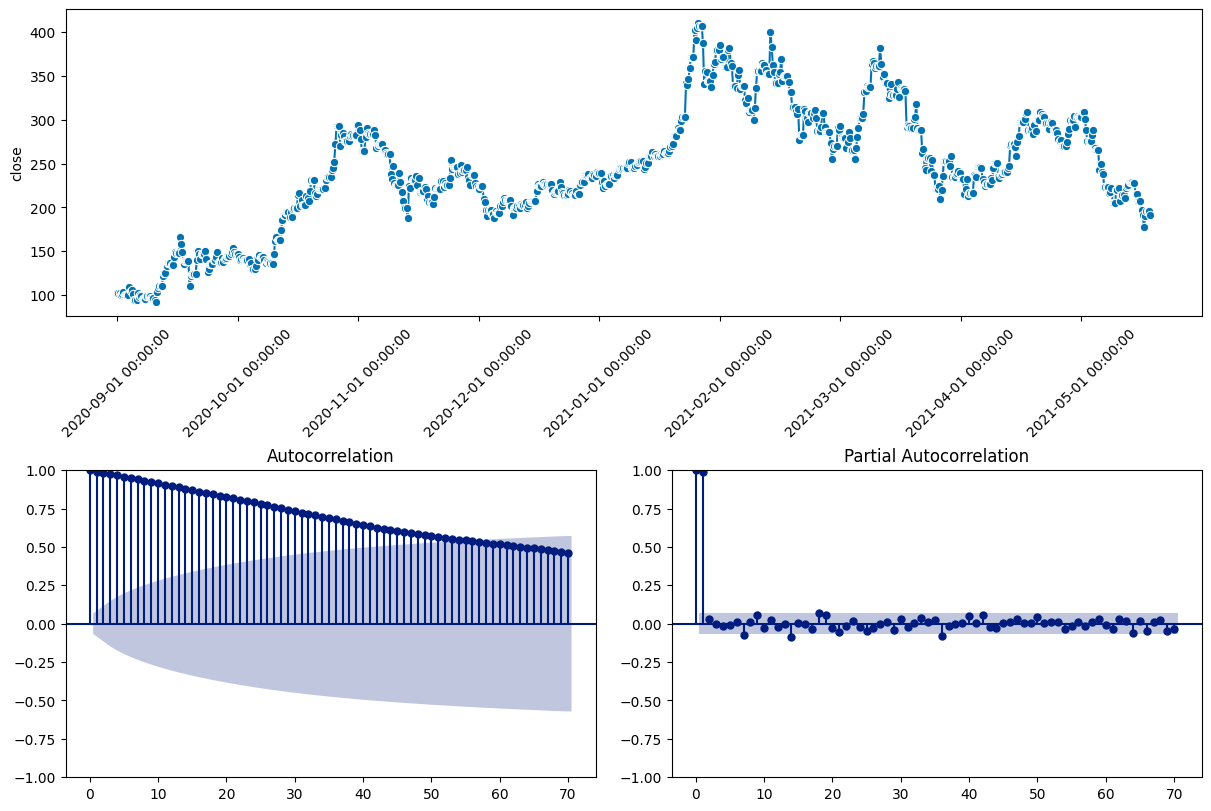

In [177]:
from sktime.utils.plotting import plot_correlations


fig, ax = plot_correlations(y_train, lags=70, acf_fft=True)
xticklabels = ax[0].set_xticklabels(
    pd.date_range(start=y_train.index.min(), end=y_train.index.max(), freq='MS').to_list(),
    rotation=45
)

- Возможный параметр модели AR, p = 1.
- При этом значительными являются лаги в 1, 7, 14 и 36 дней на диаграмме PACF.
- Резкого обрыва на диаграмме ACF нет, на PACF тоже есть пики помимо пика первого лага.
  Скорее всего надо делать подбор параметров ARMA/ARIMA.
- Много положительных корреляций на диаграмме ACF. Возможно, что требуется большой порядок дифференцирования ряда.

#### Ряд OHLC

/tmp/ipykernel_466653/3321082724.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  xticklabels = ax[0].set_xticklabels(


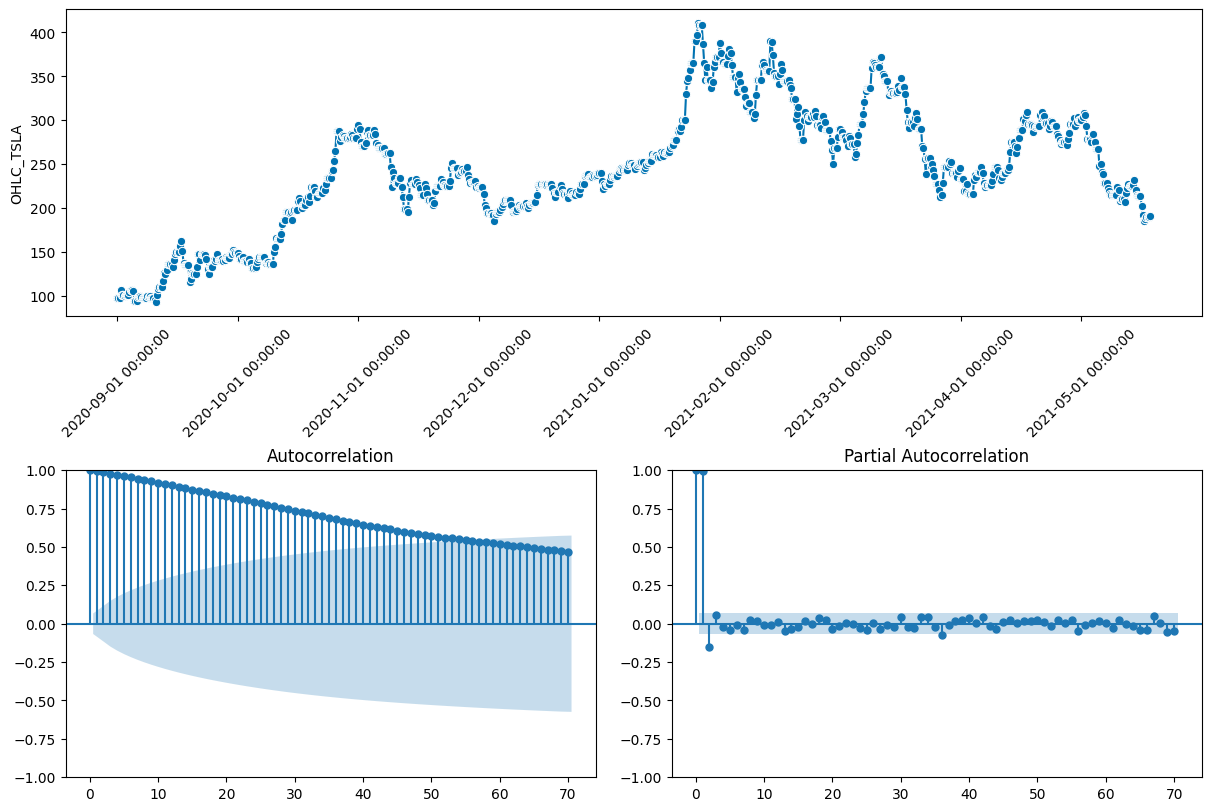

In [27]:
fig, ax = plot_correlations(X_train['OHLC_TSLA'], lags=70)
xticklabels = ax[0].set_xticklabels(
    pd.date_range(start=X_train['OHLC_TSLA'].index.min(), end=X_train['OHLC_TSLA'].index.max(), freq='MS').to_list(),
    rotation=45
)

- Возможный параметр модели AR, p = 1.
- При этом значительными являются лаги в 1, 2 и 36 дней на диаграмме PACF.
- Резкого обрыва на диаграмме ACF нет, на PACF тоже есть пики помимо пика первого и второго лагов.
  Скорее всего надо делать подбор параметров ARMA/ARIMA.
- Много положительных корреляций на диаграмме ACF. Возможно, что требуется большой порядок дифференцирования ряда.

### Тест на стационарность

In [28]:
from statsmodels.tsa.stattools import adfuller


def test_dickey_fuller(data, maxlag: int = 10, regression: str = 'c'):
    result = adfuller(data, maxlag=maxlag)
    print(f'adf: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('used lag: ', result[2])
    print('Critical values: ', result[4])
    print('----------')
    if result[0] > result[4]['5%']:
        print(f"Ряд нестационарен: статистика теста {result[0]:.3f} больше критического значения \
{result[4]['5%']:.3f} для уровня значимости 5%.")
    else:
        print('Ряд стационарен')

In [29]:
test_dickey_fuller(y_train, maxlag=70)

adf: -2.418
p-value: 0.137
used lag:  20
Critical values:  {'1%': -3.4381868797392277, '5%': -2.864999278011895, '10%': -2.568612002429454}
----------
Ряд нестационарен: статистика теста -2.418 больше критического значения -2.865 для уровня значимости 5%.


#### OHLC

In [30]:
test_dickey_fuller(X_train['OHLC_TSLA'], maxlag=70)

adf: -2.185
p-value: 0.212
used lag:  3
Critical values:  {'1%': -3.43803040357387, '5%': -2.864930295955726, '10%': -2.568575256706284}
----------
Ряд нестационарен: статистика теста -2.185 больше критического значения -2.865 для уровня значимости 5%.


Для OHLC ряд ещё более нестационарен.

### Коррелограммы дифференцированных рядов

In [31]:
import seaborn as sns
sns.set_palette("dark")


def plot_acf_pacf_derivative(data, derivative_order: int):
    d_data = data

    if derivative_order > 0:
        for order in range(1, derivative_order+1):
            d_data = d_data.diff(1).dropna()

    plot_acf_pacf(
        d_data,
        acf_lags=20, pacf_lags=20,
        size_inches=(15, 3)
    )
        
    return d_data


def plot_pdf_derivative(data, derivative_order: int):
    d_data = data

    if derivative_order > 0:
        for order in range(1, derivative_order+1):
            d_data = d_data.diff(1).dropna()

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 1.5)
    sns.histplot(data=d_data, kde=True, ax=ax)
    sns.rugplot(data=d_data, ax=ax)
    plt.show()


def time_series_derivative(data, derivative_order: int):
    d_data = data
    if derivative_order > 0:
        for order in range(1, derivative_order+1):
            d_data = d_data.diff(1).dropna()
    return d_data

#### 0-го порядка

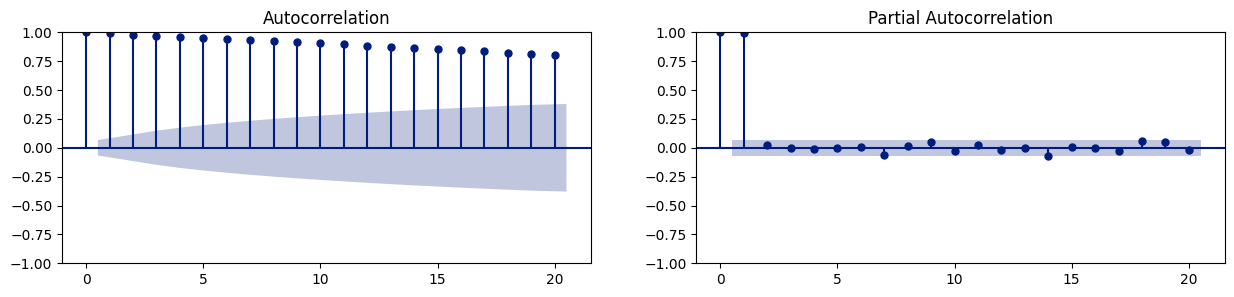

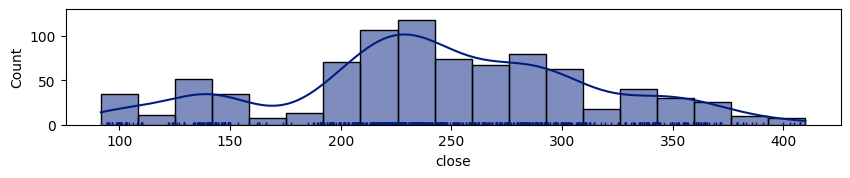

In [32]:
plot_acf_pacf_derivative(y_train, 0)
plot_pdf_derivative(y_train, 0)

Оригинальный ряд имеет выраженное не нормальное распределение.

#### 1-го порядка

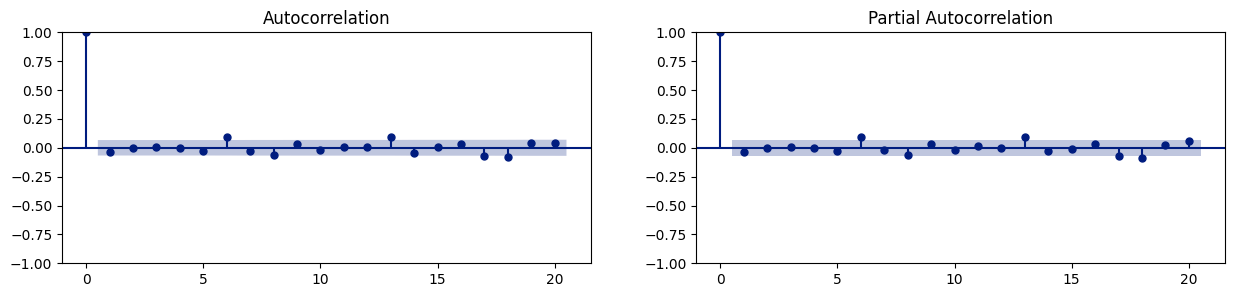

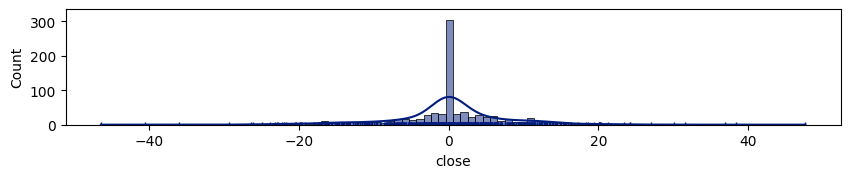

In [33]:
plot_acf_pacf_derivative(y_train, 1)
plot_pdf_derivative(y_train, 1)

Уже дифференцирование 1-го порядка сделало распределение ряда ближе к нормальному.

#### 2-го порядка

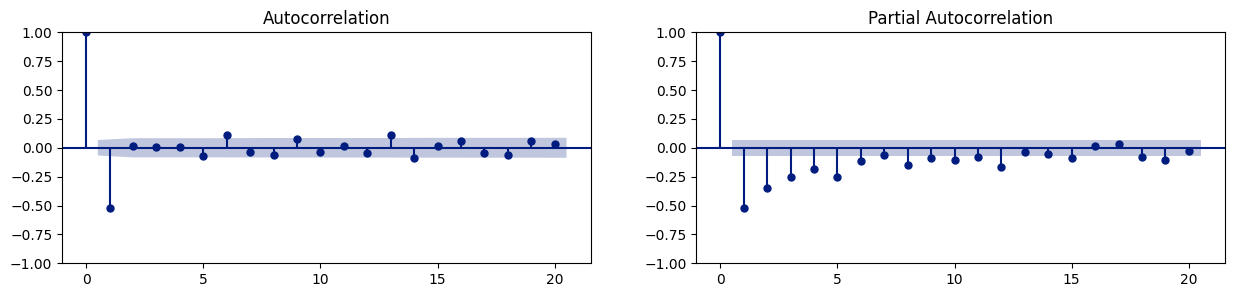

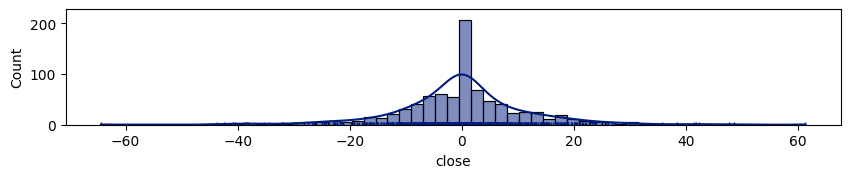

In [34]:
plot_acf_pacf_derivative(y_train, 2)
plot_pdf_derivative(y_train, 2)

#### n-го порядка

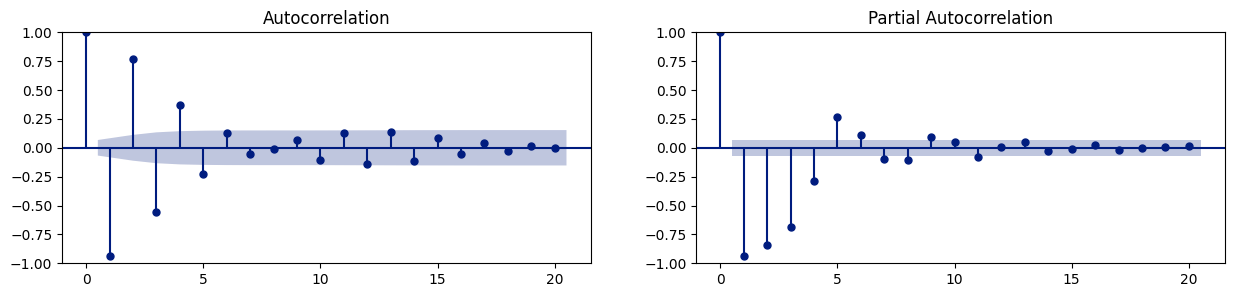

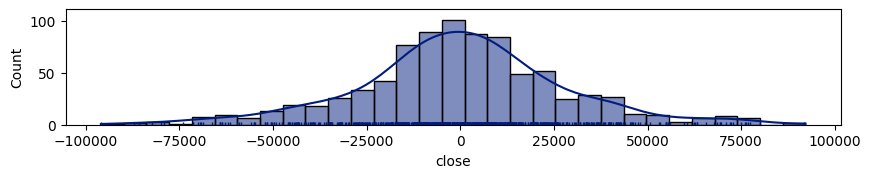

In [35]:
plot_acf_pacf_derivative(y_train, 14)
plot_pdf_derivative(y_train, 14)

Невозможно сходу подобрать параметр d для моделей типа ARMA/ARIMA. Нужно делать подбор.

### Гетероскедатичность. Волатильность.

#### Относительное изменение цены close

<AxesSubplot: ylabel='close Percentage Change'>

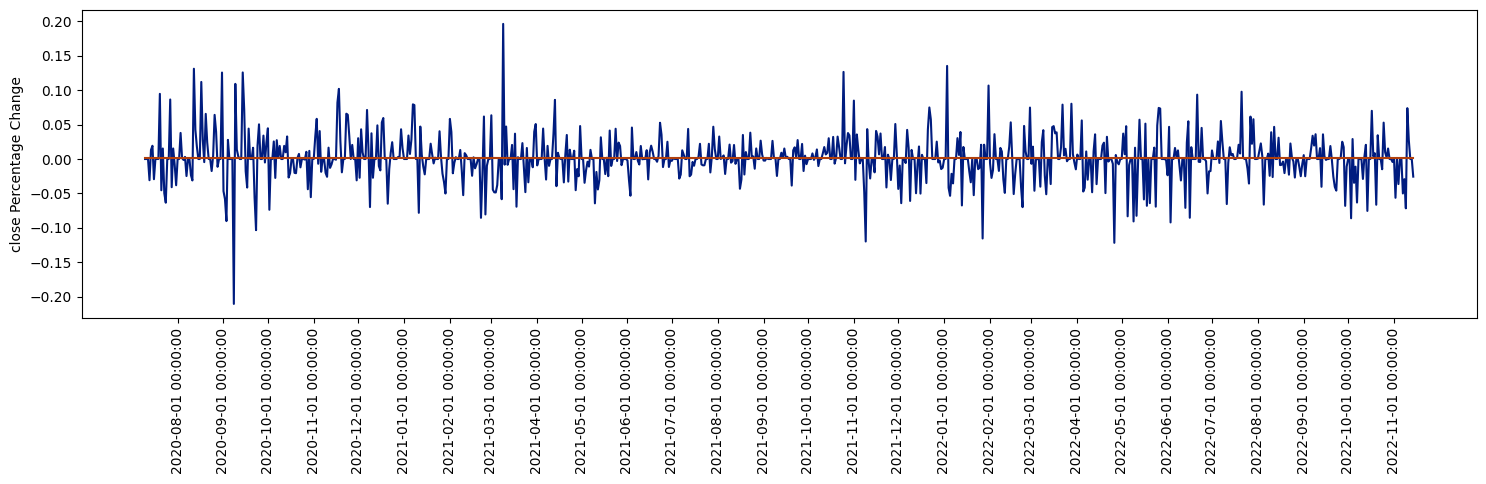

In [36]:
y_train_pct_change = y_train.pct_change(1).fillna(0)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 4)
ax.set_xticks(pd.date_range(start=y_train.index.min(), end=y_train.index.max(), freq='MS').to_list())
ax.set_xticklabels(pd.date_range(start=y_train.index.min(), end=y_train.index.max(), freq='MS').to_list(), rotation=90)
ax.set_ylabel('close Percentage Change')
sns.lineplot(x=y_train_pct_change.index, y=y_train_pct_change, ax=ax)
sns.lineplot(x=y_train_pct_change.index, y=y_train_pct_change.mean(), ax=ax)

#### Волатильность

<AxesSubplot: ylabel='GDP Volatility'>

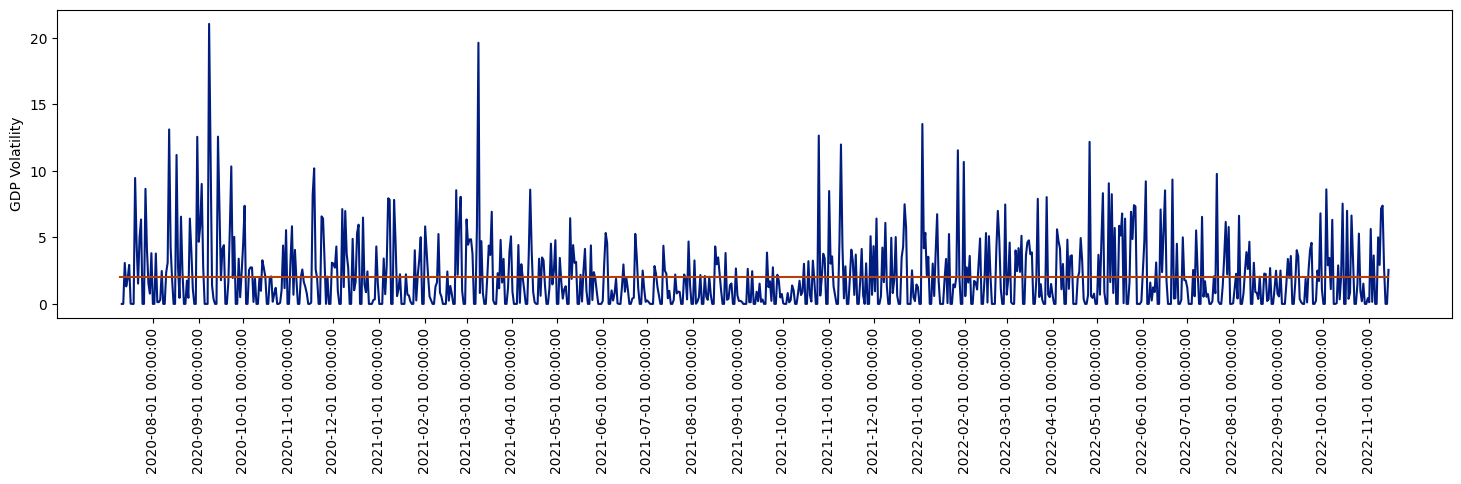

In [37]:
GDP_volatility = y_train.pct_change(1).mul(100).abs()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 4)
ax.set_xticks(pd.date_range(start=y_train.index.min(), end=y_train.index.max(), freq='MS').to_list())
ax.set_xticklabels(pd.date_range(start=y_train.index.min(), end=y_train.index.max(), freq='MS').to_list(), rotation=90)
ax.set_ylabel('GDP Volatility')
sns.lineplot(x=GDP_volatility.index, y=GDP_volatility, ax=ax)
sns.lineplot(x=GDP_volatility.index, y=GDP_volatility.mean(), ax=ax)

- Интересных периодических явлений в волатильности нет.
- Есть характерные недельные и месячные пиковые изменения.
- Летом и осенью 2021 года волатильность была заметно меньше.

### График CDF

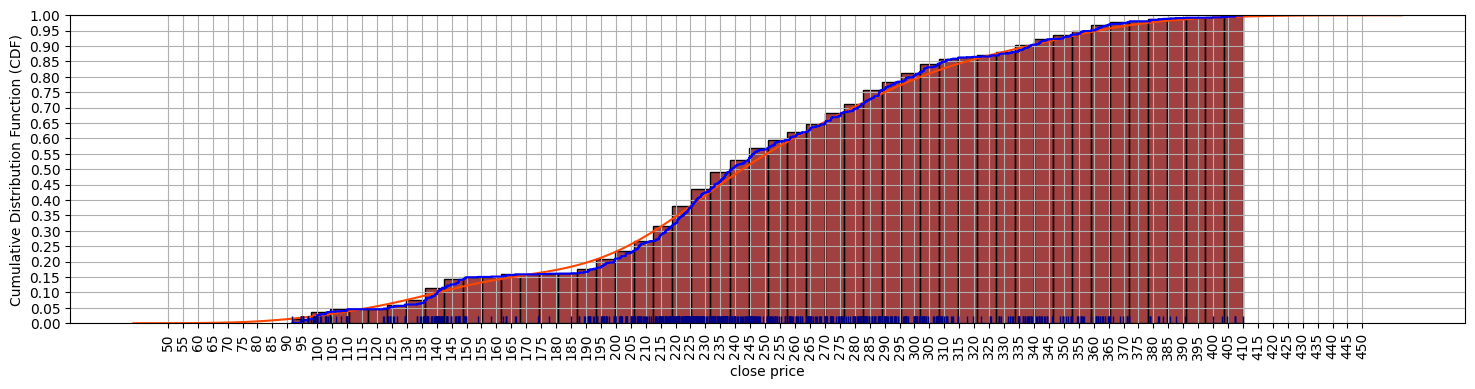

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
ax.grid()
ax.set_xlabel('close price')
ax.set_xticks(np.arange(50, 450 + 5, 5).tolist())
ax.set_xticklabels(np.round(np.arange(50, 450 + 5, 5), 2).tolist(), rotation=90)
ax.set_ylabel('Cumulative Distribution Function (CDF)')
ax.set_yticks(np.arange(0.0, 1.0 + 0.05, 0.05).tolist())
sns.kdeplot(data=y_train, color='orangered', cumulative=True, ax=ax)
sns.ecdfplot(data=y_train, color='blue', ax=ax)
sns.histplot(data=y_train, color='maroon', bins=50, stat='probability', cumulative=True, ax=ax)
sns.rugplot(data=y_train, color='navy', ax=ax)
plt.show()

#### 1-я производная

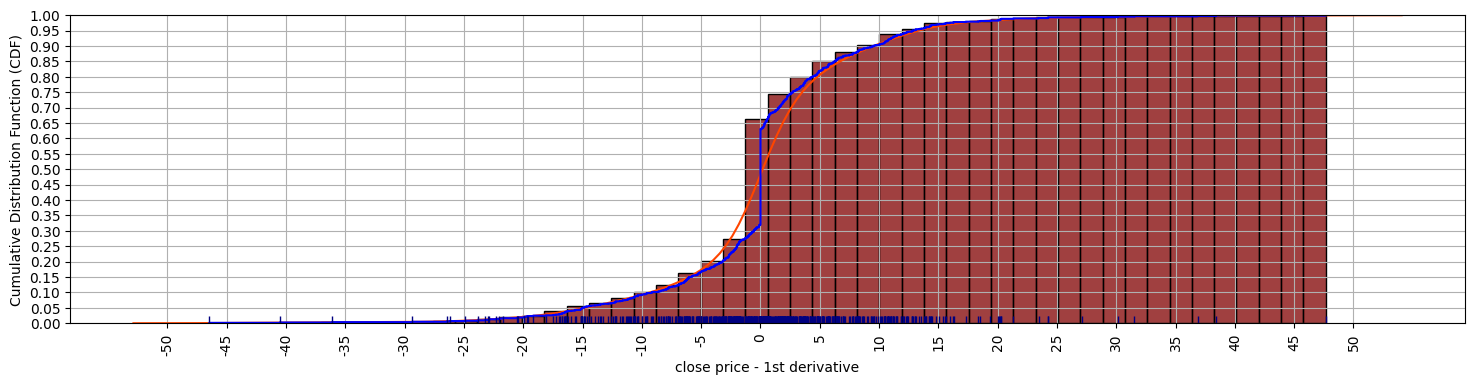

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
ax.grid()
ax.set_xlabel('close price - 1st derivative')
ax.set_xticks(np.arange(-50, 50 + 5, 5).tolist())
ax.set_xticklabels(np.round(np.arange(-50, 50 + 5, 5), 2).tolist(), rotation=90)
ax.set_ylabel('Cumulative Distribution Function (CDF)')
ax.set_yticks(np.arange(0.0, 1.0 + 0.05, 0.05).tolist())
sns.kdeplot(data=y_train.diff(1).dropna(), color='orangered', cumulative=True, ax=ax)
sns.ecdfplot(data=y_train.diff(1).dropna(), color='blue', ax=ax)
sns.histplot(data=y_train.diff(1).dropna(), color='maroon', bins=50, stat='probability', cumulative=True, ax=ax)
sns.rugplot(data=y_train.diff(1).dropna(), color='navy', ax=ax)
plt.show()

Снова видно, что дифференцирование делает ряд ближе к нормальному распределению.

In [40]:
from scipy.interpolate import CubicSpline

def cspline_interpolation(X, Y):
    spline = CubicSpline(X, Y)
    return lambda x: spline(x).tolist()


def pdf_time_series(data, column_names=['X', 'Y']):
    count, bins_count = np.histogram(data, bins=len(data))
    pdf_table = pd.DataFrame({column_names[0]: bins_count[1:], column_names[1]: count / sum(count)})
    return pdf_table


def cdf_time_series(data, column_names=['X', 'Y']):
    count, bins_count = np.histogram(data, bins=len(data))
    cdf_table = pd.DataFrame({column_names[0]: bins_count[1:], column_names[1]: np.cumsum( count / sum(count) )})
    return cdf_table


In [41]:
cdf_gdp_table = cdf_time_series(y_train, column_names=['close_growth', 'cdf'])
cdf_gdpchange = cspline_interpolation(cdf_gdp_table['close_growth'], cdf_gdp_table['cdf'])

P_growth_high = cdf_gdpchange(410) - cdf_gdpchange(300)
P_moderate_positive = cdf_gdpchange(300) - cdf_gdpchange(200)
P_negative = cdf_gdpchange(200) - cdf_gdpchange(90)

print(f"Вероятность высокой цены закрытия: {P_growth_high:.2f}")
print(f"Вероятность умеренно высокой цены закрытия: {P_moderate_positive:.2f}")
print(f"Вероятность низкой цены закрытия: {P_negative:.2f}")
print(f"Сумма: {(P_growth_high + P_moderate_positive + P_negative):.2f}")

Вероятность высокой цены закрытия: 0.20
Вероятность умеренно высокой цены закрытия: 0.60
Вероятность низкой цены закрытия: 0.21
Сумма: 1.00


<AxesSubplot: xlabel='close_growth', ylabel='pdf'>

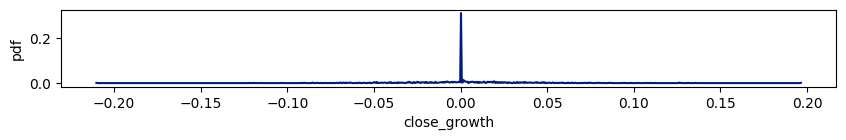

In [42]:
pdf_gdp_table = pdf_time_series(y_train.pct_change().dropna(), column_names=['close_growth', 'pdf'])
sns.lineplot(data=pdf_gdp_table, x='close_growth', y='pdf')

Изменения маловероятны, но это это видимо типиыно, если строить PDF диаграмму на всём тренировочном наборе данных для акций компаний за очень длительный период времени.

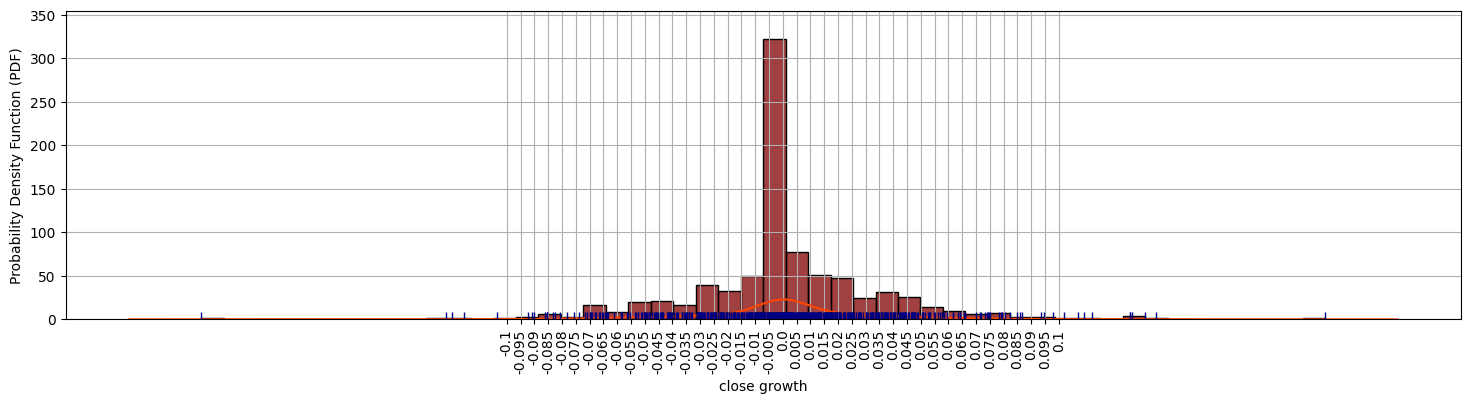

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)
ax.grid()
ax.set_xlabel('close growth')
ax.set_xticks(np.arange(-0.1, 0.1 + 0.005, 0.005).tolist())
ax.set_xticklabels(np.round(np.arange(-0.1, 0.1 + 0.005, 0.005), 4).tolist(), rotation=90)
ax.set_ylabel('Probability Density Function (PDF)')
# ax.set_yticks(np.arange(0.0, 1.0 + 0.05, 0.05).tolist())
sns.kdeplot(data=y_train.pct_change().dropna(), color='orangered', cumulative=False, common_norm=True, ax=ax)
sns.histplot(data=y_train.pct_change().dropna(), color='maroon', bins=50, cumulative=False, ax=ax)
sns.rugplot(data=y_train.pct_change().dropna(), color='navy', ax=ax)
plt.show()

#### Коррелограммы ACF и PACF для ряда волатильности close

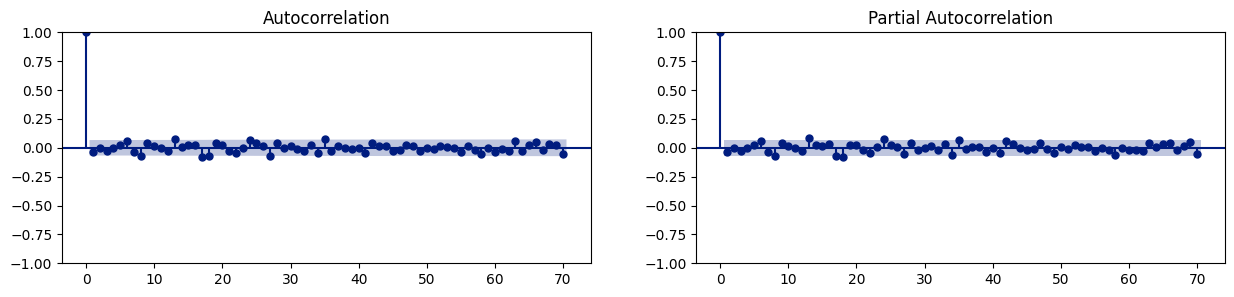

In [44]:
plot_acf_pacf(data=y_train.pct_change().dropna(), acf_lags=70, pacf_lags=70, size_inches=(15, 3))

#### Коррелограммы ACF и PACF для ряда волатильности OHLC

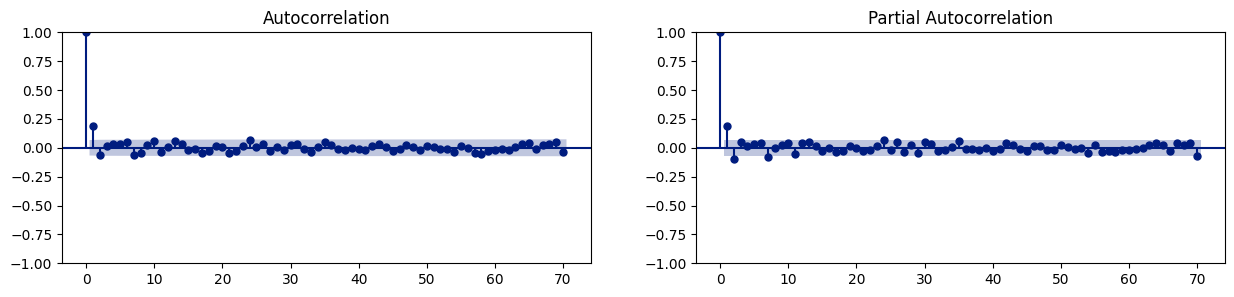

In [45]:
plot_acf_pacf(data=X_train['OHLC_TSLA'].pct_change().dropna(), acf_lags=70, pacf_lags=70, size_inches=(15, 3))

В ряде волатильности OHLC существует автокорреляция для 1,2-х дней.

#### Стационарность ряда волатильности

In [46]:
test_dickey_fuller(y_train.pct_change().dropna(), maxlag=70)

adf: -7.066
p-value: 0.000
used lag:  17
Critical values:  {'1%': -3.438168140637663, '5%': -2.864991017121922, '10%': -2.5686076019468094}
----------
Ряд стационарен


In [47]:
test_dickey_fuller(X_train['OHLC_TSLA'].pct_change().dropna(), maxlag=70)

adf: -16.165
p-value: 0.000
used lag:  2
Critical values:  {'1%': -3.43803040357387, '5%': -2.864930295955726, '10%': -2.568575256706284}
----------
Ряд стационарен


- Тест на стационарность ряда волатильности формально пройден, но автокорреляции для 1-го и 2-го лаго выше всё же имеют место.
- Есть и другие "дальние" лаги.
- К тому же это всё за длительность в пару лет, когда происходили взлёты и падения.

### Добавление признаков по автокорреляциям

In [48]:
# Лаги в 1 день, 1неделю, 2 недели.
dataset_joined_with_tech["close_1d"] = dataset_joined_with_tech['close'].shift(1)
dataset_joined_with_tech["close_7d"] = dataset_joined_with_tech['close'].shift(7)
dataset_joined_with_tech["close_14d"] = dataset_joined_with_tech['close'].shift(14)

# Добавим для проверки дополнительно несколько недель
dataset_joined_with_tech["close_21d"] = dataset_joined_with_tech['close'].shift(21)
dataset_joined_with_tech["close_28d"] = dataset_joined_with_tech['close'].shift(28)
dataset_joined_with_tech["close_35d"] = dataset_joined_with_tech['close'].shift(35)

# Добавим для проверки дополнительно месяц
dataset_joined_with_tech["close_30d"] = dataset_joined_with_tech['close'].shift(30)

# Лаг в 36 дней
dataset_joined_with_tech["close_36d"] = dataset_joined_with_tech['close'].shift(36)

dataset_joined_with_tech["OHLC_TSLA_1d"] = dataset_joined_with_tech['OHLC_TSLA'].shift(1)
dataset_joined_with_tech["OHLC_TSLA_2d"] = dataset_joined_with_tech['OHLC_TSLA'].shift(2)
dataset_joined_with_tech["OHLC_TSLA_7d"] = dataset_joined_with_tech['OHLC_TSLA'].shift(7)
dataset_joined_with_tech["OHLC_TSLA_14d"] = dataset_joined_with_tech['OHLC_TSLA'].shift(14)

### Корреляции между рядами

In [49]:
y_train, y_test, data_train, data_test = model_selection.temporal_train_test_split(
    y=dataset_joined_with_tech['close'], X=dataset_joined_with_tech, test_size=0.05
)
print(f"y_train: {y_train.shape}")
print(f"X_train: {data_train.shape}")
print('--------------------------------')
print(f"y_test: {y_test.shape}")
print(f"X_test: {data_test.shape}")

y_train: (858,)
X_train: (858, 56)
--------------------------------
y_test: (46,)
X_test: (46, 56)


#### Линейные корреляции

In [50]:
corr = data_train.corr('pearson')

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

/tmp/ipykernel_466653/977965362.py:19: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .set_precision(2)\


- Далее будут удалены признаки, которые слабо линейно коррелируют с целевым
  многомерным рядом open, high, low, close для цен на акции Tesla (TSLA).
- Исключение будет сделано только для бинарных признаков weekend и holiday. Они могут быть полезны особенно для моделей глубокого обучения, как "сигнальные".
- Стоит также оставить лаги в 1-у и 2-е недели как минимум.
- Также полезно будет полезно оставить признаки скользащих средних.
- На всякий случай стоит оставить RSI_TSLA, как признак, который является в значительной мере управляющим/сигнальным для продаж в теханализе.

#### Ранговые корреляции по Спирмену

In [51]:
corr = data_train.corr('spearman')

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

/tmp/ipykernel_466653/72200842.py:19: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .set_precision(2)\


## Baseline model - Наивная модель предсказания

In [55]:
from sktime.forecasting import base
from sktime.forecasting import naive
from sktime.performance_metrics.forecasting import mean_squared_error

baseline_model = naive.NaiveForecaster(strategy='last', sp=7)
baseline_model.fit(y_train)

forecasting_horizon = base.ForecastingHorizon(y_test.index, is_relative=False)
y_test_pred = baseline_model.predict(forecasting_horizon)

print(f"Test RMSE: {mean_squared_error(y_test, y_test_pred, square_root=True):.4f}")
print(f"Test Pearson correlation: {np.corrcoef(np.array([y_test.to_list(), y_test_pred.to_list()]))[0, 1]:.4f}")

Test RMSE: 37.7503
Test Pearson correlation: 0.0296


## Модель ARIMA

#### Без сезонности

In [64]:
from sktime.forecasting import arima

arima_model = arima.ARIMA(
    order=(1, 2, 1), seasonal_order=(0, 0, 0, 0), suppress_warnings=True
)
arima_model.fit(y_train)

forecasting_horizon = base.ForecastingHorizon(y_test.index, is_relative=False)
y_test_pred = arima_model.predict(forecasting_horizon)

print(f"Test RMSE: {mean_squared_error(y_test, y_test_pred, square_root=True):.4f}")
print(f"Test Pearson correlation: {np.corrcoef(np.array([y_test.to_list(), y_test_pred.to_list()]))[0, 1]:.4f}")

Test RMSE: 23.2435
Test Pearson correlation: 0.8637


Ошибка даже немного хуже.

##### Невязки (остатки)

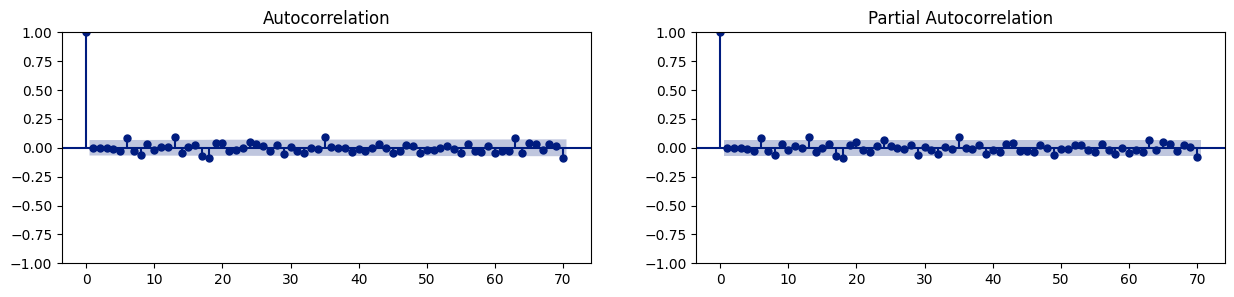

adf: -7.445
p-value: 0.000
used lag:  17
Critical values:  {'1%': -3.4381774989729816, '5%': -2.8649951426291, '10%': -2.568609799556849}
----------
Ряд стационарен


In [65]:
plot_acf_pacf(data=arima_model.predict_residuals(y_train).dropna(), acf_lags=70, pacf_lags=70, size_inches=(15, 3))
test_dickey_fuller(arima_model.predict_residuals(y_train).dropna(), maxlag=70)

p = 6, d = 2, q = 7 - на глаз

In [70]:
from sktime.forecasting import arima

arima_model = arima.ARIMA(
    order=(6, 2, 7), seasonal_order=(0, 0, 0, 0), suppress_warnings=True
)
arima_model.fit(y_train)

forecasting_horizon = base.ForecastingHorizon(y_test.index, is_relative=False)
y_test_pred = arima_model.predict(forecasting_horizon)

print(f"Test RMSE: {mean_squared_error(y_test, y_test_pred, square_root=True):.4f}")
print(f"Test Pearson correlation: {np.corrcoef(np.array([y_test.to_list(), y_test_pred.to_list()]))[0, 1]:.4f}")

Test RMSE: 20.9970
Test Pearson correlation: 0.8636


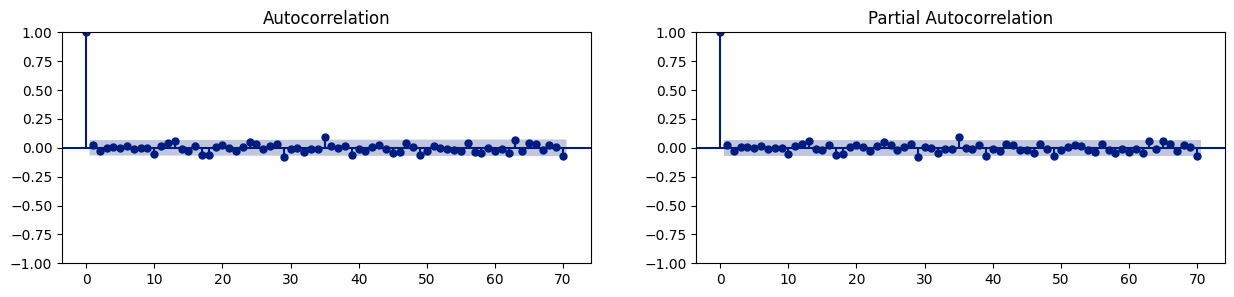

adf: -28.463
p-value: 0.000
used lag:  0
Critical values:  {'1%': -3.4380213934599957, '5%': -2.8649263237651375, '10%': -2.5685731407954586}
----------
Ряд стационарен


In [71]:
plot_acf_pacf(data=arima_model.predict_residuals(y_train).dropna(), acf_lags=70, pacf_lags=70, size_inches=(15, 3))
test_dickey_fuller(arima_model.predict_residuals(y_train).dropna(), maxlag=70)

- Коррелограммы остатков уже в большей степени походят на коррелограммы белого шума при p = 6, d = 2, q = 7.
- Значения d > 2 резко ухудшают ошибку RMSE.

#### Добавление сезонности

S = 7

In [111]:
from sktime.forecasting import arima

arima_model = arima.ARIMA(
    order=(6, 2, 7), seasonal_order=(0, 1, 0, 7), suppress_warnings=True
)
arima_model.fit(y_train)

forecasting_horizon = base.ForecastingHorizon(y_test.index, is_relative=False)
y_test_pred = arima_model.predict(forecasting_horizon)

print(f"Test RMSE: {mean_squared_error(y_test, y_test_pred, square_root=True):.4f}")
print(f"Test Pearson correlation: {np.corrcoef(np.array([y_test.to_list(), y_test_pred.to_list()]))[0, 1]:.4f}")

Test RMSE: 24.1771
Test Pearson correlation: 0.9199


- Ошибка немного возросла.
- НО коэффициент линейной корреляции на _тестовом_ наборе теперь `≅0.92`.

S = 3

In [112]:
from sktime.forecasting import arima

arima_model = arima.ARIMA(
    order=(6, 2, 7), seasonal_order=(0, 1, 0, 3), suppress_warnings=True
)
arima_model.fit(y_train)

forecasting_horizon = base.ForecastingHorizon(y_test.index, is_relative=False)
y_test_pred = arima_model.predict(forecasting_horizon)

print(f"Test RMSE: {mean_squared_error(y_test, y_test_pred, square_root=True):.4f}")
print(f"Test Pearson correlation: {np.corrcoef(np.array([y_test.to_list(), y_test_pred.to_list()]))[0, 1]:.4f}")

Test RMSE: 14.1902
Test Pearson correlation: 0.8676


- Ошибка заметно снизилась.
- Коэффициент корреляции на тестовом наборе не поменялся.

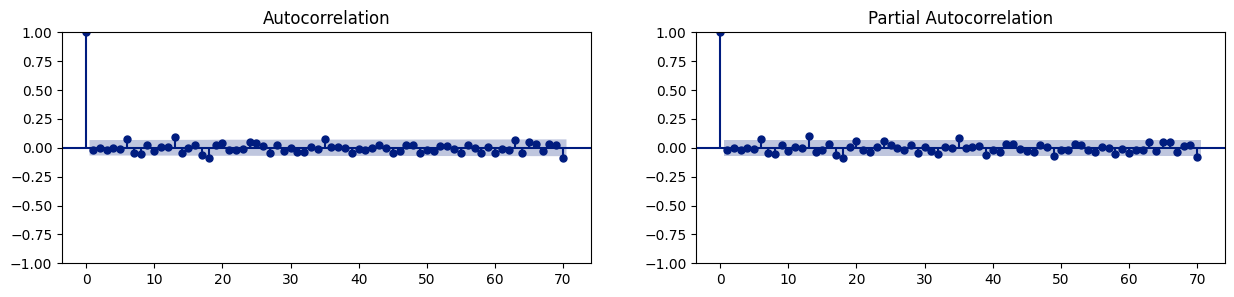

adf: -7.577
p-value: 0.000
used lag:  17
Critical values:  {'1%': -3.4381774989729816, '5%': -2.8649951426291, '10%': -2.568609799556849}
----------
Ряд стационарен


In [113]:
plot_acf_pacf(data=arima_model.predict_residuals(y_train).dropna(), acf_lags=70, pacf_lags=70, size_inches=(15, 3))
test_dickey_fuller(arima_model.predict_residuals(y_train).dropna(), maxlag=70)

Стоит выбирать более простую модель: ${\color{orange}\mathtt{ARIMA(p=6, d=2, q=7)(P=0, D=1, Q=0, S=3)}}$

## Auto SARIMA

In [168]:
from sktime.forecasting import arima

# Параметры, найденные вручную.
# order=(6, 2, 7),
# seasonal_order=(0, 1, 0, 3),
auto_arima_model = arima.AutoARIMA(
    start_p=1, d=1, start_q=1,
    max_p=15, max_d=5, max_q=15,
    start_P=0, D=1, start_Q=0,
    max_P=15, max_D=5, max_Q=15,
    max_order=150,
    sp=3, seasonal=True,
    stationary=False,
    information_criterion='aicc',
    alpha=0.05, test='adf',
    n_jobs=-1, maxiter=500,
    suppress_warnings=True,
    error_action='ignore',
    random=False, random_state=None, n_fits=500,
    scoring='mse', with_intercept=True
)
auto_arima_model.fit(y_train)

forecasting_horizon = base.ForecastingHorizon(y_test.index, is_relative=False)
y_test_pred = auto_arima_model.predict(forecasting_horizon)

print(f"Test RMSE: {mean_squared_error(y_test, y_test_pred, square_root=True):.4f}")
print(f"Test Pearson correlation: {np.corrcoef(np.array([y_test.to_list(), y_test_pred.to_list()]))[0, 1]:.4f}")

/home/sorcerer/Projects/DataScience/Stock/Work/Dione/dione/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Test RMSE: 16.9446
Test Pearson correlation: 0.8831


In [169]:
auto_arima_model.get_fitted_params()

{'ar.S.L3': -0.9132922389922731,
 'ar.S.L6': -0.7321675193111319,
 'ar.S.L9': -0.6202802272223605,
 'ar.S.L12': -0.5430566745013828,
 'ar.S.L15': -0.4676197526442779,
 'ar.S.L18': -0.4843806805248573,
 'ar.S.L21': -0.4368563175573869,
 'ar.S.L24': -0.2923151028473933,
 'ar.S.L27': -0.23931470510521888,
 'ar.S.L30': -0.16727767603405097,
 'ar.S.L33': -0.0824453819081988,
 'sigma2': 71.63167234679996,
 'order': (0, 1, 0),
 'seasonal_order': (11, 1, 0, 3),
 'aic': 6100.080111646963,
 'aicc': 6100.451098567296,
 'bic': 6157.079285972426,
 'hqic': 6121.908887118635}

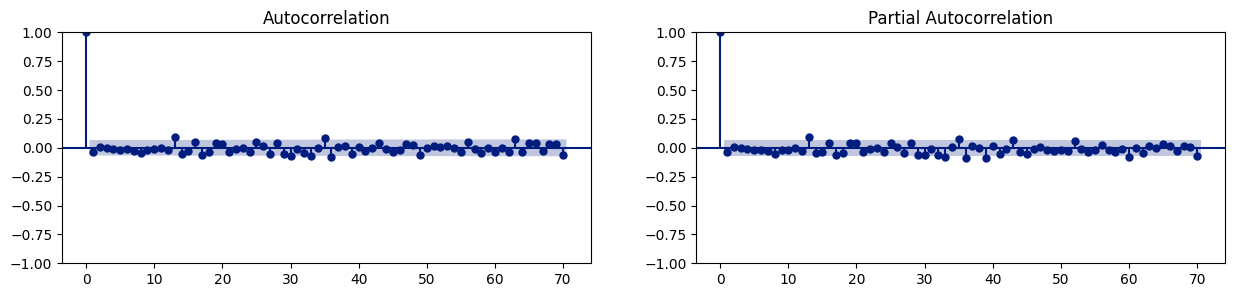

adf: -5.503
p-value: 0.000
used lag:  42
Critical values:  {'1%': -3.4384090190455994, '5%': -2.865097201355259, '10%': -2.5686641656756155}
----------
Ряд стационарен


In [170]:
plot_acf_pacf(data=auto_arima_model.predict_residuals(y_train).dropna(), acf_lags=70, pacf_lags=70, size_inches=(15, 3))
test_dickey_fuller(auto_arima_model.predict_residuals(y_train).dropna(), maxlag=70)

В плане значения ошибки RMSE найденная вручную модель SARIMA лучше.

## MSTL

In [173]:
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import DecomposeResult


# seasonal.STL()

# mstl = STL(y_train, periods=[3, 7, 28])
# res = mstl.fit()

# ax = res.plot()